# Predicting Economic Distress Among Patients Diagnosed With Cancer

## Overview

Cancer patients have to copy not only with understanding and analazying all the treatment and care options but also with the financial distress that come with the management of the disease. Since copy with stress plays a big role on the effectiveness of the recovery, it is crucial to identify cancer patients that are more likely to be impacted by economic hardship.

This research uses a few machine learning models (logistic regression, support vector machine, decision tree, and random forest) to predict economic hardship among cancer patients.


## Data

The data comes from the 2016 Medical Expenditure Panel Survey (MEPS), specifically the full-year consolidated data file. The analytic sample consist of all patients who have been diagnosed with any type of cancer. 

The label variable is a dichotomous variable that expresses economic stress. The target variable was built using five variables: 
- money borrowed or in debt 
- unable to cover medical bills
- self or family file bankruptcy
- worry pay medical bills
- worry income stability

For the purpose of this analysis, we will clasify cancer patients experiencing financial as those who answered positively to at least one the economic hardship index variables.

The feature variables include age, gender, level of education, insurance, race/ethnicity, total health care expenditures, total out-of-pockets costs, and comorbities(heart, stroke, emphysema, high cholesterol, diabetes, arthristis, and asthma.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
color = sns.color_palette()

import warnings
warnings.filterwarnings("ignore")

In [2]:
df= pd.read_csv('economic_distress_cancer/final.csv')

In [3]:
df.columns


Index(['econstres', 'famsize', 'age', 'gender', 'raceth', 'edu', 'heart',
       'stroke', 'emphy', 'choles', 'diabe', 'arthr', 'asthm', 'pover',
       'insurance', 'totexp', 'totslf'],
      dtype='object')

In [4]:
df.head(3)

,econstres,famsize,age,gender,raceth,edu,heart,stroke,emphy,choles,diabe,arthr,asthm,pover,insurance,totexp,totslf
0,0,2,84.0,0,white,11.0,0,0,0,1,1,1,0,5,insured,20027,3269
1,0,1,72.0,1,white,12.0,0,1,0,1,0,0,0,4,insured,3184,440
2,0,2,78.0,1,white,14.0,0,0,0,1,0,1,0,5,insured,8268,1478


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1195 entries, 0 to 1194
Data columns (total 17 columns):
econstres    1195 non-null int64
famsize      1195 non-null int64
age          1179 non-null float64
gender       1195 non-null int64
raceth       1195 non-null object
edu          1192 non-null float64
heart        1195 non-null int64
stroke       1195 non-null int64
emphy        1195 non-null int64
choles       1195 non-null int64
diabe        1195 non-null int64
arthr        1195 non-null int64
asthm        1195 non-null int64
pover        1195 non-null int64
insurance    1195 non-null object
totexp       1195 non-null int64
totslf       1195 non-null int64
dtypes: float64(2), int64(13), object(2)
memory usage: 158.8+ KB


In [6]:
# Displays the statistic details or descriptive statistics of each variable
df.describe().T

,count,mean,std,min,25%,50%,75%,max
econstres,1195.0,0.301255,0.458995,0.0,0.0,0.0,1.0,1.0
famsize,1195.0,2.106276,1.067842,1.0,1.0,2.0,2.0,5.0
age,1179.0,65.765055,13.788849,22.0,57.0,68.0,76.0,85.0
gender,1195.0,0.410042,0.492047,0.0,0.0,0.0,1.0,1.0
edu,1192.0,13.674497,2.139098,11.0,12.0,13.0,16.0,17.0
heart,1195.0,0.102929,0.303993,0.0,0.0,0.0,0.0,1.0
stroke,1195.0,0.114644,0.318726,0.0,0.0,0.0,0.0,1.0
emphy,1195.0,0.066946,0.250032,0.0,0.0,0.0,0.0,1.0
choles,1195.0,0.567364,0.495649,0.0,0.0,1.0,1.0,1.0
diabe,1195.0,0.199163,0.399538,0.0,0.0,0.0,0.0,1.0


## Data Preprocessing

### Missing Data

In [7]:
miss= df[df.isnull().any(axis=1)]
miss.head(3)

,econstres,famsize,age,gender,raceth,edu,heart,stroke,emphy,choles,diabe,arthr,asthm,pover,insurance,totexp,totslf
74,0,2,72.0,0,white,NaN,0,1,0,0,0,1,0,4,insured,5003,326
129,1,2,NaN,0,black,12.0,0,0,0,1,0,1,0,4,insured,53531,4861
297,0,1,NaN,1,white,14.0,0,0,0,0,1,0,0,2,insured,24698,496


In [8]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)*100
missing_data = pd.concat([total,percent],axis=1, keys=['Total Missing', 'Percent'])
missing_data[missing_data['Total Missing']>0]

,Total Missing,Percent
age,16,1.338912
edu,3,0.251046


There are two variables that have missing data: age and education. The percentage of missing data is very low. Age is missing 1.3% while education 0.25%. Given that the number of cases of missing values is extremely small, we removed all data for an observation that has one or more missing values (Listwise deletion).

In [9]:
# Drop the rows where at least one element is missing.
df.dropna(inplace=True)

In [10]:
df.head(3)

,econstres,famsize,age,gender,raceth,edu,heart,stroke,emphy,choles,diabe,arthr,asthm,pover,insurance,totexp,totslf
0,0,2,84.0,0,white,11.0,0,0,0,1,1,1,0,5,insured,20027,3269
1,0,1,72.0,1,white,12.0,0,1,0,1,0,0,0,4,insured,3184,440
2,0,2,78.0,1,white,14.0,0,0,0,1,0,1,0,5,insured,8268,1478


### Cleaning Data

In [11]:
df.dtypes

econstres      int64
famsize        int64
age          float64
gender         int64
raceth        object
edu          float64
heart          int64
stroke         int64
emphy          int64
choles         int64
diabe          int64
arthr          int64
asthm          int64
pover          int64
insurance     object
totexp         int64
totslf         int64
dtype: object

Age and education are represented as float numerical data (number that has a decimal place). We want to convert these variables specified as a whole number (integers).

In [12]:
# Convert dtype from float64 to int64
for col in ['age', 'edu']:
    df[col] = df[col].astype(np.int64)

In [13]:
df.head(3)

,econstres,famsize,age,gender,raceth,edu,heart,stroke,emphy,choles,diabe,arthr,asthm,pover,insurance,totexp,totslf
0,0,2,84,0,white,11,0,0,0,1,1,1,0,5,insured,20027,3269
1,0,1,72,1,white,12,0,1,0,1,0,0,0,4,insured,3184,440
2,0,2,78,1,white,14,0,0,0,1,0,1,0,5,insured,8268,1478


In [14]:
df['insurance'].unique()

array(['insured', 'uninsured'], dtype=object)

In [15]:
df['insurance'].value_counts()

insured      1152
uninsured      24
Name: insurance, dtype: int64

In [16]:
cleanup_nums= {"insurance": {"insured":1, "uninsured":0}}
df.replace(cleanup_nums, inplace=True)
df.head(3)

,econstres,famsize,age,gender,raceth,edu,heart,stroke,emphy,choles,diabe,arthr,asthm,pover,insurance,totexp,totslf
0,0,2,84,0,white,11,0,0,0,1,1,1,0,5,1,20027,3269
1,0,1,72,1,white,12,0,1,0,1,0,0,0,4,1,3184,440
2,0,2,78,1,white,14,0,0,0,1,0,1,0,5,1,8268,1478


### Create dummy variables

In [17]:
df['raceth'].unique()

array(['white', 'black', 'asian', 'hispanic'], dtype=object)

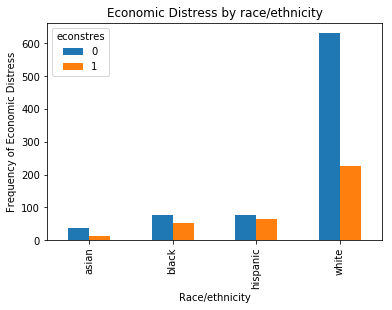

In [18]:
pd.crosstab(df.raceth,df.econstres).plot(kind='bar')
plt.title('Economic Distress by race/ethnicity')
plt.xlabel('Race/ethnicity')
plt.ylabel('Frequency of Economic Distress')
plt.show()

White individuals show more economic hardshhip followed by hispanic and black individuals. 

In [19]:
df_raceth = pd.get_dummies(df['raceth'], drop_first=False, prefix='raceth',prefix_sep='_')
df_new = df.join(df_raceth)
df= df_new.drop(['raceth'], axis=1)
df.columns.values

array(['econstres', 'famsize', 'age', 'gender', 'edu', 'heart', 'stroke',
       'emphy', 'choles', 'diabe', 'arthr', 'asthm', 'pover', 'insurance',
       'totexp', 'totslf', 'raceth_asian', 'raceth_black',
       'raceth_hispanic', 'raceth_white'], dtype=object)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1176 entries, 0 to 1194
Data columns (total 20 columns):
econstres          1176 non-null int64
famsize            1176 non-null int64
age                1176 non-null int64
gender             1176 non-null int64
edu                1176 non-null int64
heart              1176 non-null int64
stroke             1176 non-null int64
emphy              1176 non-null int64
choles             1176 non-null int64
diabe              1176 non-null int64
arthr              1176 non-null int64
asthm              1176 non-null int64
pover              1176 non-null int64
insurance          1176 non-null int64
totexp             1176 non-null int64
totslf             1176 non-null int64
raceth_asian       1176 non-null uint8
raceth_black       1176 non-null uint8
raceth_hispanic    1176 non-null uint8
raceth_white       1176 non-null uint8
dtypes: int64(16), uint8(4)
memory usage: 200.8 KB


## Exploratory Data Analysis
To explore the economic hardship variable and the variables associated with it.

In [21]:
df['econstres'].value_counts()

0    822
1    354
Name: econstres, dtype: int64

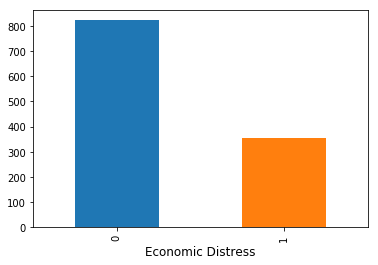

In [22]:
df['econstres'].value_counts().plot(kind='bar')
plt.xlabel('Economic Distress', fontsize=12)
plt.show()

Around 1/3 of the individuals report economic distress of having cancer

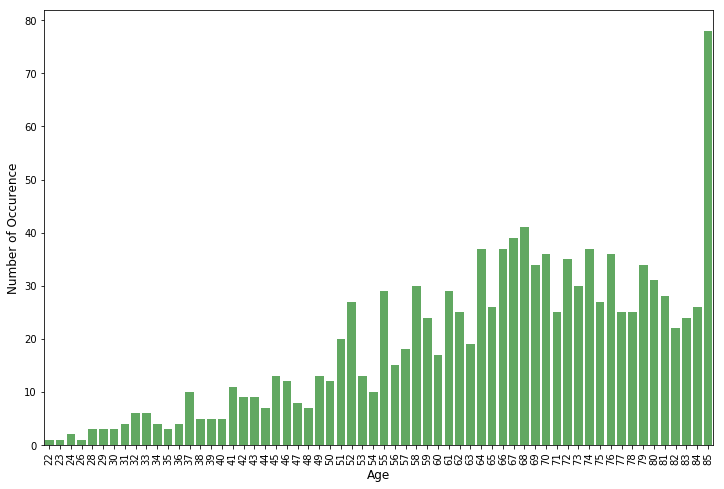

In [23]:
plt.figure(figsize=(12,8))
sns.countplot(x='age', data=df, alpha=0.8, color=color[2])
plt.ylabel('Number of Occurence', fontsize=12)
plt.xlabel('Age', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

The majority of the individuals are over 50 years old. The youngest is 22. There are a large number who are 85+ years old.

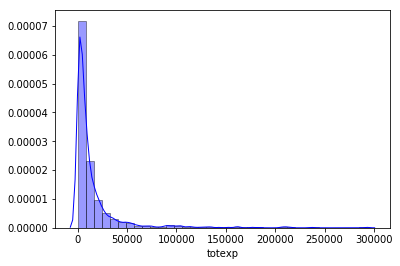

In [24]:
# seaborn histogram
sns.distplot(df['totexp'], hist=True, kde=True,
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 1}
             )
plt.show()

There are a large number of observations with zero total expenditures. Total expenditure is max capped at $300,000.

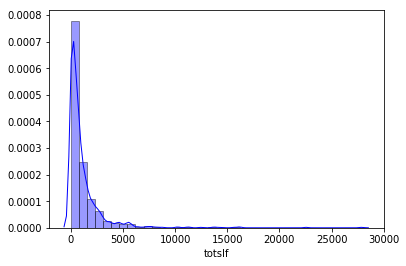

In [25]:
# seaborn histogram
sns.distplot(df['totslf'], hist=True, kde=True,
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 1}
             )
plt.show()

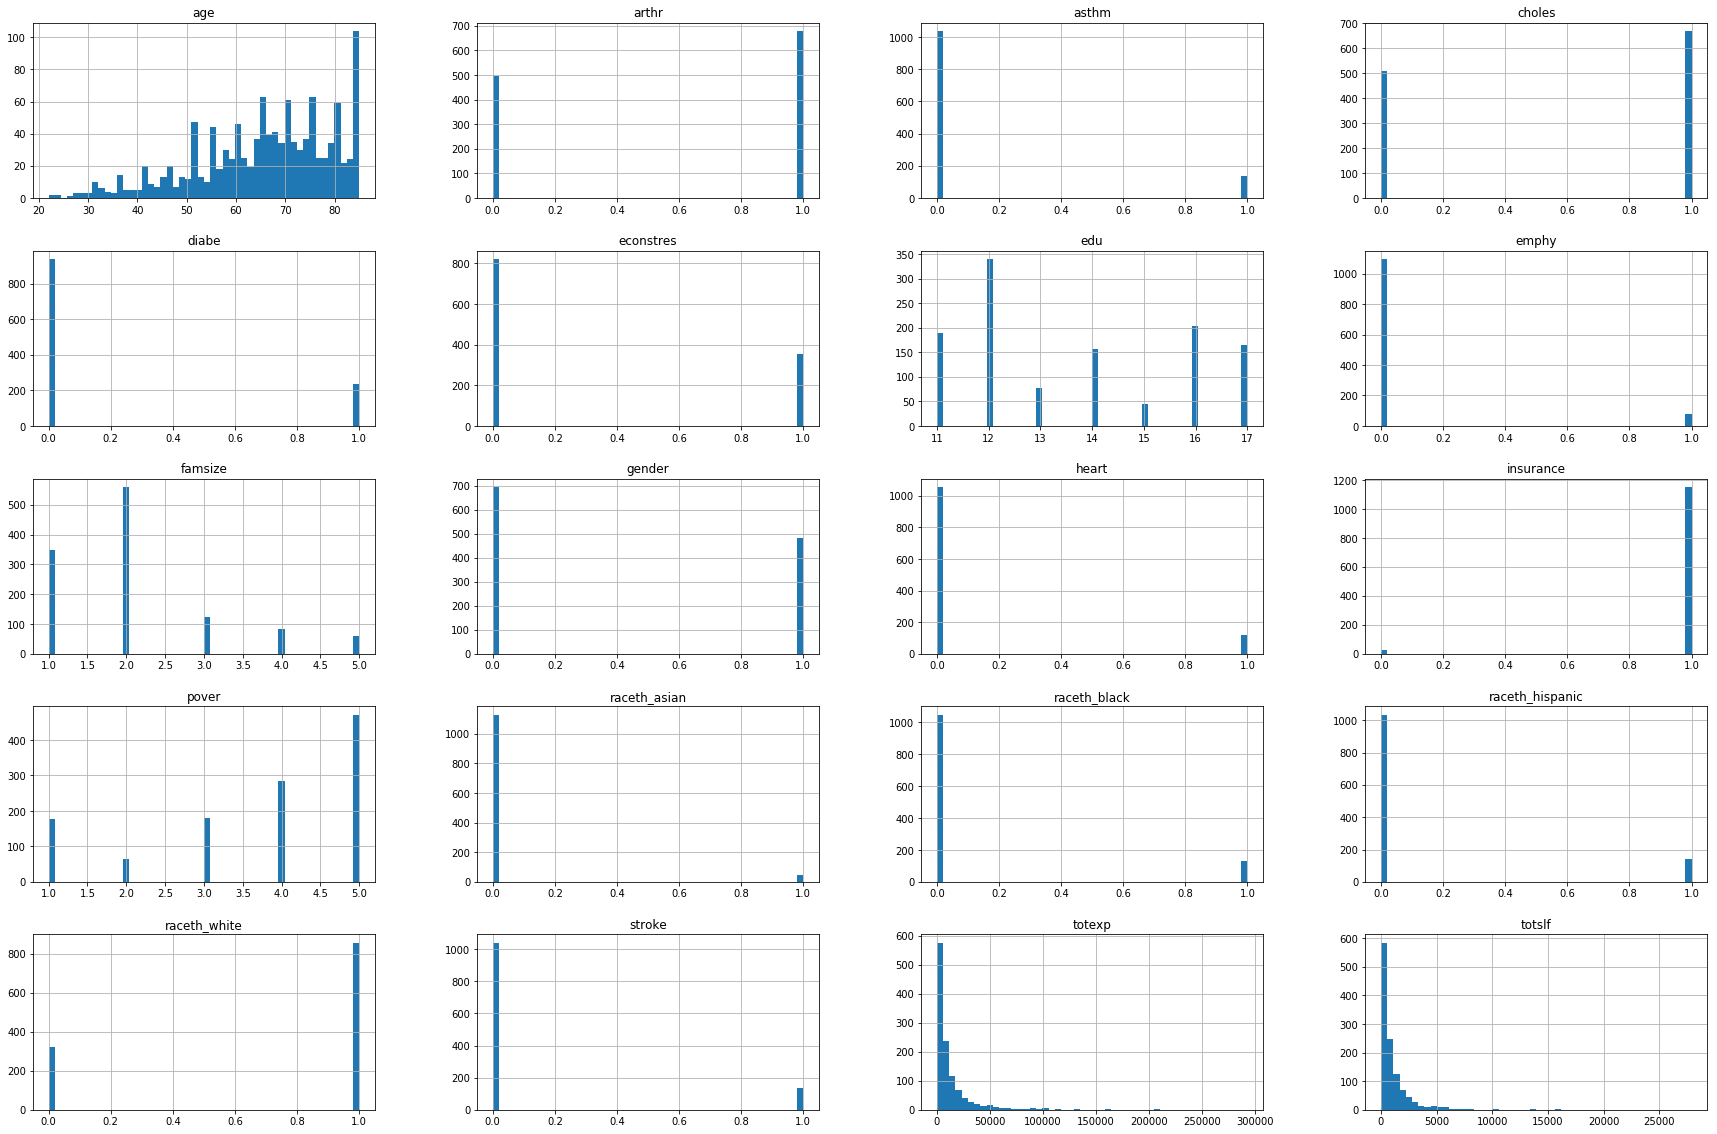

In [26]:
#Distribution of the features
df.hist(bins=50, figsize=(30,20))
plt.show()

The majority of the families is composed of 1 or 2 members. The distribution of the total expenditures and total out-of-pocket costs are similar. 

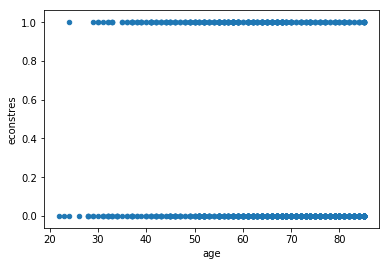

In [27]:
var = 'age'
data = pd.concat([df['econstres'], df[var]], axis=1)
data.plot.scatter(x=var, y='econstres')
plt.show()

Patients under their 20s are few in both groups, specially for those having financial distress.

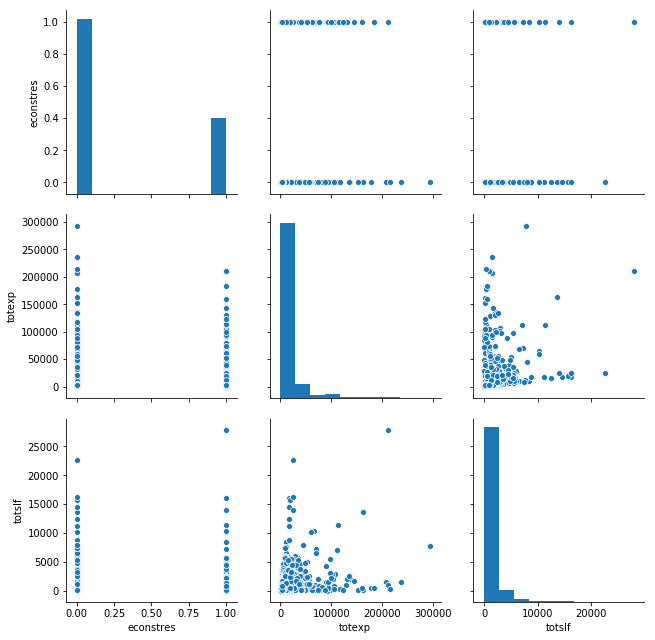

In [28]:
sns.set
cols=['econstres', 'totexp', 'totslf']
sns.pairplot(df[cols], height=3.0)
plt.show()

Under economic hardship, total out-of-pocket costs shows an outlier while total expenditures do not show outliers. 

Correlation Matrix

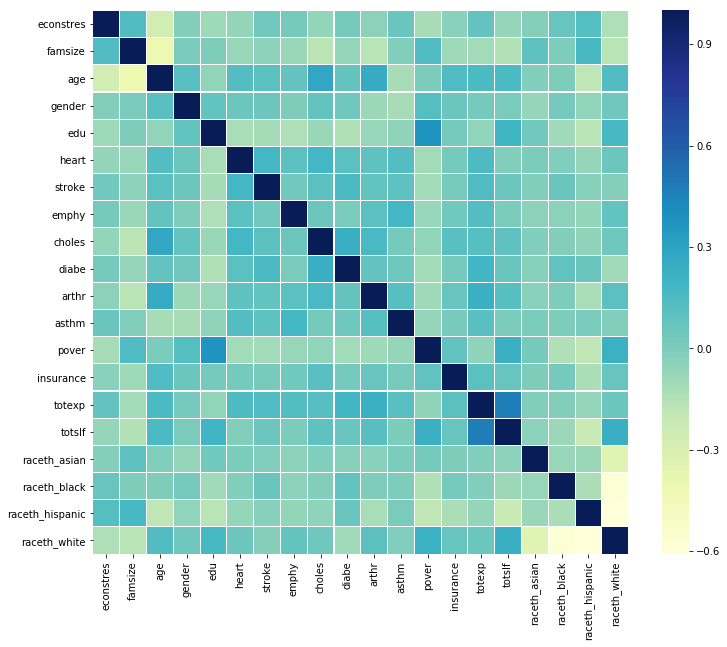

In [29]:
corrmat =df.corr(method='spearman')
f,ax = plt.subplots(figsize=(12,10))
sns.heatmap(corrmat, ax=ax, cmap='YlGnBu', linewidths=0.1)
plt.show()

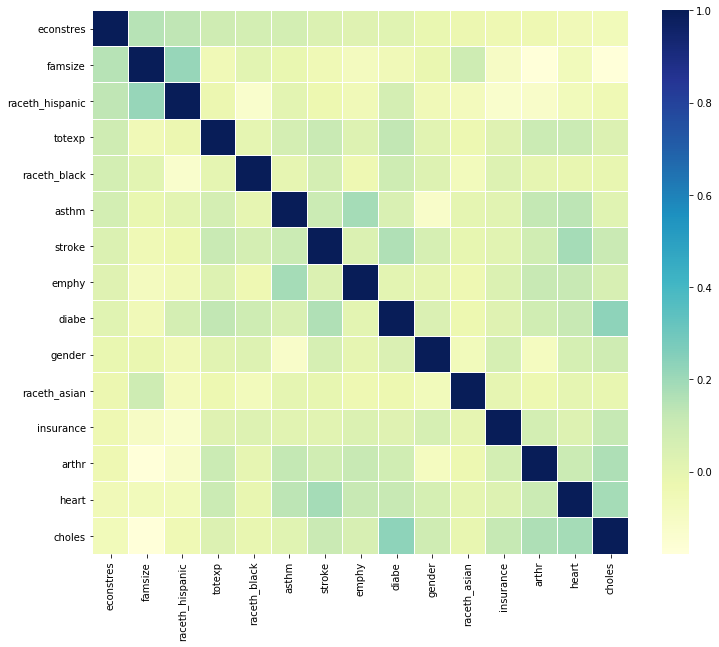

In [30]:
k = 15 #number of variables for heatmap
cols = corrmat.nlargest(k, 'econstres')['econstres'].index
cm = np.corrcoef(df[cols].values.T)
f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(cm, ax=ax, cmap="YlGnBu", linewidths=0.1, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

The variables that have a high correlation with the label variable are family size, hispanic, total expenditure, black, asthma, stroke and emphizema.

### Feature Engineering 

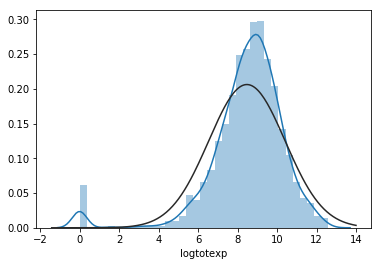

In [31]:
# Given that totexp is skewed to the right, convert it to log
df['logtotexp']=np.log1p(df['totexp'])
sns.distplot(df['logtotexp'], fit=norm)
plt.show()

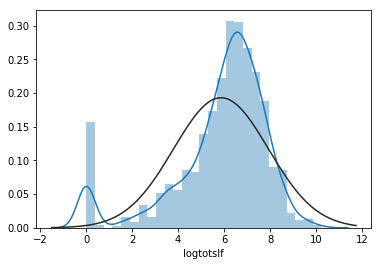

In [32]:
# Given that totslf is skewed to the right, transform it to log
df['logtotslf']=np.log1p(df['totslf'])
sns.distplot(df['logtotslf'], fit=norm)
plt.show()

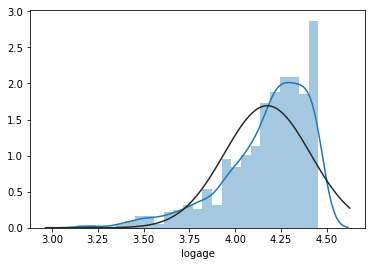

In [33]:
# Given that totexp is skewed to the right, convert it to log
df['logage']=np.log1p(df['age'])
sns.distplot(df['logage'], fit=norm)
plt.show()

In [34]:
df.head(3)

,econstres,famsize,age,gender,edu,heart,stroke,emphy,choles,diabe,...,insurance,totexp,totslf,raceth_asian,raceth_black,raceth_hispanic,raceth_white,logtotexp,logtotslf,logage
0,0,2,84,0,11,0,0,0,1,1,...,1,20027,3269,0,0,0,1,9.904887,8.092545,4.442651
1,0,1,72,1,12,0,1,0,1,0,...,1,3184,440,0,0,0,1,8.066208,6.089045,4.290459
2,0,2,78,1,14,0,0,0,1,0,...,1,8268,1478,0,0,0,1,9.020269,7.299121,4.369448


## Modeling
For this analysis the transformated variables (or features) are not used. The original features were used.

### Extract the target variable
Create an y series with the target variable (econstres)

In [35]:
y = df.econstres.copy()

### Create an X dataframe with the input features

Drop not so important features

In [36]:
X = df.drop(['econstres', 'logtotexp', 'logtotslf', 'logage'], axis=1)

### Split the dataset into training and validation
The training set is used to build the machine learning models.
The test set is used to see how well the model performs on unseen data.

In [37]:
from sklearn.model_selection import train_test_split

In [38]:
#80% go into the training set, 20% in the validation test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Logistic Regression

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve,roc_auc_score

log_model = LogisticRegression(fit_intercept=False)
log_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [40]:
y_pred = log_model.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred)) # Model Accuracy, how often is the classifier correct?
print('ROC AUC score:', roc_auc_score(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred))
print('Confusion Matrix:')
pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    columns=['Predicted Not EconomicHardship', 'Predicted EconomicHardship'],
    index=['True Not EconomicHardship', 'True EconomicHardship']
)

Accuracy: 0.7330508474576272
ROC AUC score: 0.570387706438223
Classification Report:
             precision    recall  f1-score   support

          0       0.75      0.95      0.84       169
          1       0.59      0.19      0.29        67

avg / total       0.70      0.73      0.68       236

Confusion Matrix:


,Predicted Not EconomicHardship,Predicted EconomicHardship
True Not EconomicHardship,160,9
True EconomicHardship,54,13


### Support Vector Classification

In [41]:
from sklearn.svm import SVC
svc_model = SVC()
svc_model.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [42]:
y_pred = svc_model.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred)) # Model Accuracy, how often is the classifier correct?
print('ROC AUC score:', roc_auc_score(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred))
print('Confusion Matrix:')
pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    columns=['Predicted Not EconomicHardship', 'Predicted EconomicHardship'],
    index=['True Not EconomicHardship', 'True EconomicHardship']
)

Accuracy: 0.7161016949152542
ROC AUC score: 0.5
Classification Report:
             precision    recall  f1-score   support

          0       0.72      1.00      0.83       169
          1       0.00      0.00      0.00        67

avg / total       0.51      0.72      0.60       236

Confusion Matrix:


,Predicted Not EconomicHardship,Predicted EconomicHardship
True Not EconomicHardship,169,0
True EconomicHardship,67,0


### Decision Tree

In [43]:
from sklearn.tree import DecisionTreeClassifier
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [44]:
y_pred = tree_model.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred)) # Model Accuracy, how often is the classifier correct?
print('ROC AUC score:', roc_auc_score(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred))
print('Confusion Matrix:')
pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    columns=['Predicted Not EconomicHardship', 'Predicted EconomicHardship'],
    index=['True Not EconomicHardship', 'True EconomicHardship']
)

Accuracy: 0.597457627118644
ROC AUC score: 0.5162501103947718
Classification Report:
             precision    recall  f1-score   support

          0       0.73      0.70      0.71       169
          1       0.31      0.33      0.32        67

avg / total       0.61      0.60      0.60       236

Confusion Matrix:


,Predicted Not EconomicHardship,Predicted EconomicHardship
True Not EconomicHardship,119,50
True EconomicHardship,45,22


### Random Forest with 1000 trees

In [45]:
from sklearn.ensemble import RandomForestClassifier
rf_model=RandomForestClassifier(n_estimators=1000)
rf_model.fit(X_train,y_train)


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [46]:
y_pred = rf_model.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred)) # Model Accuracy, how often is the classifier correct?
print('ROC AUC score:', roc_auc_score(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred))
print('Confusion Matrix:')
pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    columns=['Predicted Not EconomicHardship', 'Predicted EconomicHardship'],
    index=['True Not EconomicHardship', 'True EconomicHardship']
)

Accuracy: 0.6864406779661016
ROC AUC score: 0.546851541111013
Classification Report:
             precision    recall  f1-score   support

          0       0.74      0.87      0.80       169
          1       0.41      0.22      0.29        67

avg / total       0.64      0.69      0.65       236

Confusion Matrix:


,Predicted Not EconomicHardship,Predicted EconomicHardship
True Not EconomicHardship,147,22
True EconomicHardship,52,15


### To Plot multiple ROC curves in one plot

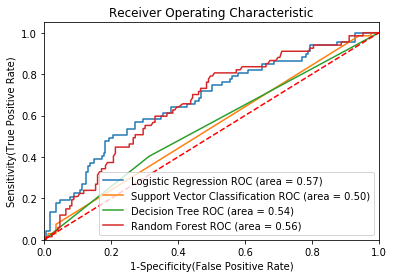

In [47]:
from sklearn import metrics

plt.figure()

# Add the models to the list that you want to view on the ROC plot
models = [
{
    'label': 'Logistic Regression',
    'model': LogisticRegression(fit_intercept=False),
},
{
    'label': 'Support Vector Classification',
    'model': SVC(probability=True),
},
    {
    'label': 'Decision Tree',
    'model': DecisionTreeClassifier(),
},
{
    'label': 'Random Forest',
    'model': RandomForestClassifier(n_estimators=1000),
}
]

# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
    model.fit(X_train, y_train) # train the model
    y_pred=model.predict(X_test) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(X_test)[:,1])
# Calculate Area under the curve to display on the plot
    auc = metrics.roc_auc_score(y_test,model.predict(X_test))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()   # Display

Based on the AUC scores, the logistic regression and the random forest are the best models. Overall, the best model is the logistic regression since it produces roughly the same result as the random forest and takes a lot less time to process than the random forest.

In [48]:
#Using the log features
X_tfm = df.drop(['econstres', 'totexp', 'totslf', 'age'], axis=1)

In [49]:
X_train_tfm, X_test_tfm, y_train_tfm, y_test_tfm = train_test_split(X_tfm, y, test_size=0.2, random_state=0)

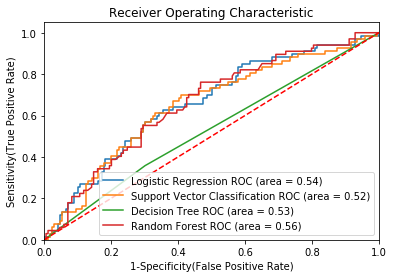

In [50]:
plt.figure()

# Add the models to the list that you want to view on the ROC plot
models = [
{
    'label': 'Logistic Regression',
    'model': LogisticRegression(fit_intercept=False),
},
{
    'label': 'Support Vector Classification',
    'model': SVC(probability=True),
},
    {
    'label': 'Decision Tree',
    'model': DecisionTreeClassifier(),
},
{
    'label': 'Random Forest',
    'model': RandomForestClassifier(n_estimators=1000),
}
]

# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
    model.fit(X_train_tfm, y_train_tfm) # train the model
    y_pred_tfm=model.predict(X_test_tfm) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(X_test_tfm)[:,1])
# Calculate Area under the curve to display on the plot
    auc = metrics.roc_auc_score(y_test,model.predict(X_test_tfm))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()   # Display